# Example Processing for High-resolution DEM
## Setup and Installation of Python environment
This Notebook and the Python Code to extract Connected Components from longitudinal river profiles requires several python modules to be installed.

Using `conda`, you can create your own environment *DEM_CC* and install the required modules (note that you need to have the `conda-forge` channel in ~/.condarc):
```
conda create -y --name DEM_CC
conda activate DEM_CC
conda install -y ipykernel pandas numpy geopandas rasterio matplotlib scipy kneed scikit-image tqdm seaborn
```

You can do similar steps in your `pip` environment.


### Jupyter Notebook and conda

Note that you may have to add the conda environment `DEM_CC` to the Jupyter Notebook environment. After the step below, you can chose that as your active kernel. If it is not automatically chosen, you can select from the menu: Kernel -> Change kernel -> DEM_CC.

```
python -m ipykernel install --user --name=DEM_CC
```

## Installation of LSDTopoTools
Furthermore, the Code requires an installed instance of LSDTopoTools2. A detailed inscription is on their [webpage(https://lsdtopotools.github.io/LSDTT_documentation/LSDTT_installation.html).

You can use the Docker version - but if you want full versability (and if you work on a Linux/Mac System), you may want to compile a local version. Running an Ubuntu 19.04 or 20.04 should allow you to install this locally (without much intervention). If you don't know what you are doing, likely the `docker` version is more useful.

```
cd ~
wget https://raw.githubusercontent.com/LSDtopotools/LSDTT_Edinburgh_scripts/master/LSDTT_native_linux_setup.sh
sh LSDTT_native_linux_setup.sh
```
Make sure to add this path to your environment variable PATH to call the various subscripts of LSDTopoTools.

    
## Installing DEM_ConnectedComponents
Download the most recent source code:

```
git clone https://github.com/UP-RS-ESP/DEM_ConnectedComponents.git
```

You can simply add the path to the existing *PYTHONPATH* variable. If the string *CONNECTEDCOMPONENT* contains the path, you can use

```
export PYTHONPATH=$PYTHONPATH:./<CONNECTEDCOMPONENT/>src
```

For example:
```
export PYTHONPATH=$PYTHONPATH:./DEM_ConnectedComponents/src
```

Alternatively, you can install (make sure you are in the *DEM_CC* conda environment:
```
python setup.py install
```
    
# DEM Preprocessing
There are a few steps that need to be done before the `DEM_connectedcomponents` can be run. These include pre-processing steps with `LSDTopoTools` or a similar environment.

The DEM should be in a projected coordinate system (e.g., UTM).

## *lsdtt-chi-mapping 1*
Generate a chi map using `lsdtt-chi-mapping`. This requires a driver file and a DEM in binary format.

First, convert the DEM to BIL format (usually from GeoTIFF):
```
gdal_translate -of ENVI testClip_3m.tif testClip_3m.bil
```

Next, generate a driver file
```
read path: /home/bodo/DEM_ConnectedComponents
read fname: testClip_3m

write path: /home/bodo/DEM_ConnectedComponents
write fname: testClip_3m

# Parameter for filling the DEM
min_slope_for_fill: 0.0001

# print statements 
print_channels_to_csv: true
print_segmented_M_chi_map_to_csv: true
#print_junctions_to_csv: true

# method to extract channels
print_area_threshold_channels: true

# Parameters for selecting channels and basins
threshold_contributing_pixels: 1000
maximum_basin_size_pixels: 11111111
find_complete_basins_in_window: false
test_drainage_boundaries: false

# Parameters for chi analysis
A_0: 1
m_over_n: 0.45
n_iterations: 20
target_nodes: 80
minimum_segment_length: 10
sigma: 10.0
skip: 2
```

and run with:
```
lsdtt-chi-mapping testClip_3m.driver
```


## *lsdtt-chi-mapping 2*
Generate a chi map using `lsdtt-chi-mapping`. This requires a driver file and a DEM in binary format.

First, convert the DEM to BIL format (usually from GeoTIFF):
```
gdal_translate -of ENVI debrisBasins.tif debrisBasins.bil
```

Next, generate a driver file
```
read path: /home/bodo/DEM_ConnectedComponents
read fname: debrisBasins

write path: /home/bodo/DEM_ConnectedComponents
write fname: debrisBasins

# Parameter for filling the DEM
min_slope_for_fill: 0.0001

# print statements 
print_channels_to_csv: true
print_segmented_M_chi_map_to_csv: true
#print_junctions_to_csv: true

# method to extract channels
print_area_threshold_channels: true

# Parameters for selecting channels and basins
threshold_contributing_pixels: 1000
maximum_basin_size_pixels: 11111111
find_complete_basins_in_window: false
test_drainage_boundaries: false

# Parameters for chi analysis
A_0: 1
m_over_n: 0.45
n_iterations: 20
target_nodes: 80
minimum_segment_length: 10
sigma: 10.0
skip: 2
```

and run with:
```
lsdtt-chi-mapping debrisBasins.driver
```



# Run DEM_ConnectedComponents
First step is to merge outputs from LSDTT. Here, the name *testClip* contains the information from LSDTT.

In [1]:
from connectedComponents import *

#path = "~/DEM_ConnectedComponents/"
path = "./"

#load output from LSDTT
lsdttTable = mergeLSDTToutput(fname = "testClip", path = path, resolution=3, epsg = 32719) 

Merging CSV files from LSDTopoTools...


First, we need to find a good pixel threshold for calculating channel slope using 10 random channels within the area of interest. This is constrained by the polygon stored in *testMask.shp*. The *mask* parameter is optional.

Calculating channel-slope using different regression lengths: 100%|██████████| 25/25 [01:23<00:00,  3.32s/it]


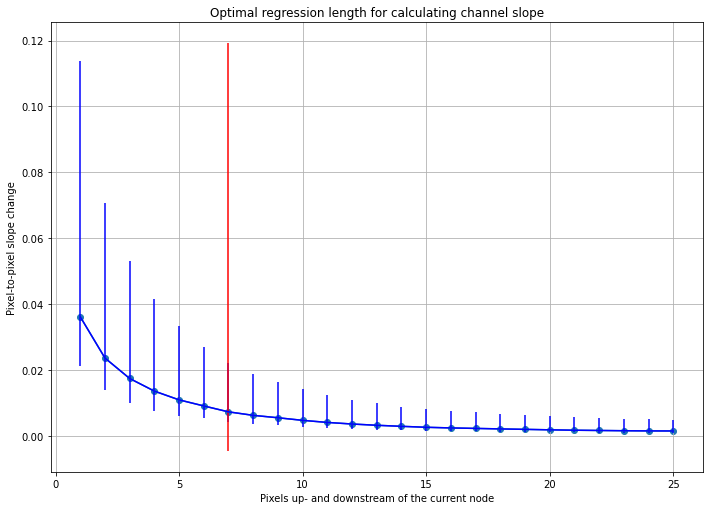

Out of the given pixel thresholds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25], the recommended value is 7.


In [2]:
pixThr = findPixelThreshold(lsdttTable, sampleStreams = 10 , mask = "testMask.shp", path = path)

We now get the channel network of debris-flow sample regions using and use these to extract the a reliable slope-change threshold to constrain the ConnectedComponents.

Merging CSV files from LSDTopoTools...


Finding CC using different slope-change thresholds: 100%|██████████| 12/12 [00:47<00:00,  3.95s/it]

Out of the provided slope-change thresholds [0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26], the recommended value is 0.23


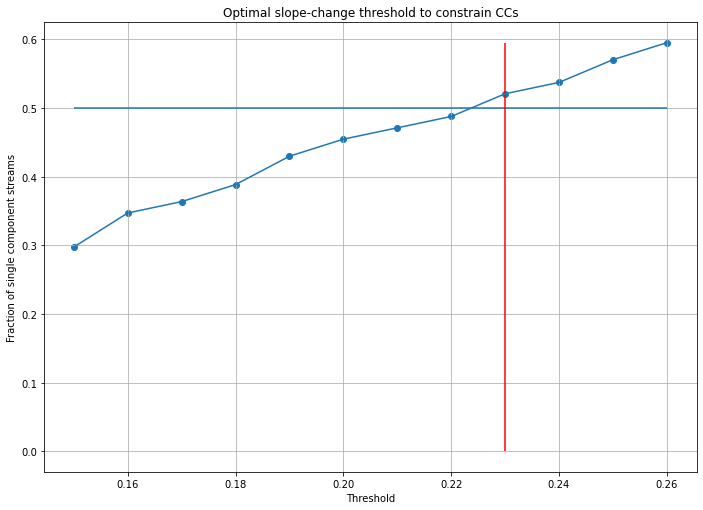

In [3]:
debrisSamples = mergeLSDTToutput(fname = "debrisBasins_final", path = path, resolution=3, epsg = 32719)
dSlopeThr = findDSlopeThresholdDebrisSamples(debrisSamples, pixThr = 7, minCCLength = 10, bridge = 5, thresholdRange = np.arange(0.15,0.26,0.01))

If there are no debris-flow sample regions available, you may also find a threshold by comparing slope change along a pre-defined distance, e.g. 10 pixels. This function also allows you to provide a list of different values and retrieve the mean of the 5th and 95th percentile.

100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


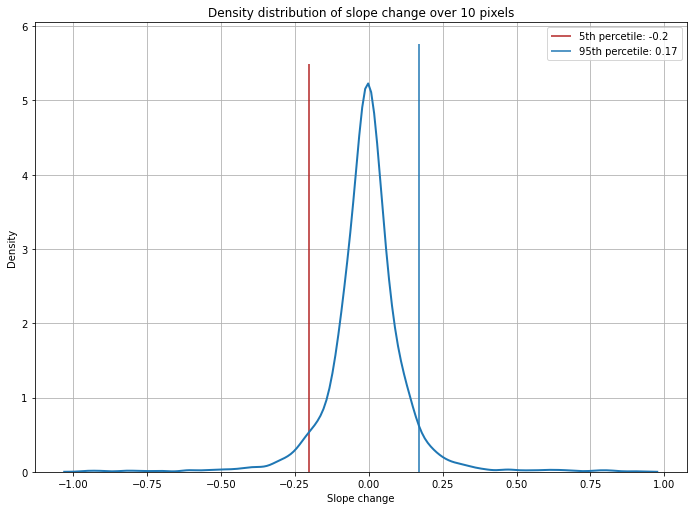

Investigating slope change over 10 pixels and the reccomend value is 0.19


In [4]:
dSlopeThr2 = findDSlopeThresholdAlternative(lsdttTable, dist = 10, pixThr = 7, sampleStreams = 10, mask = "testMask.shp", path = path)

Let's try this with two different distances 5 and 10:

100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


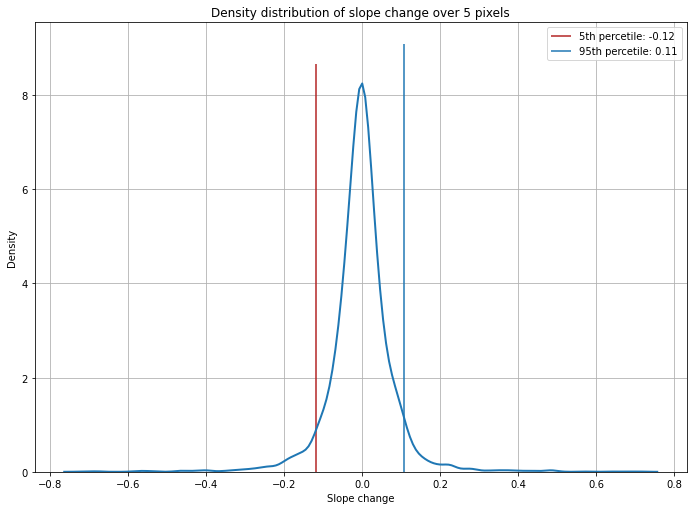

Investigating slope change over 5 pixels and the reccomend value is 0.11


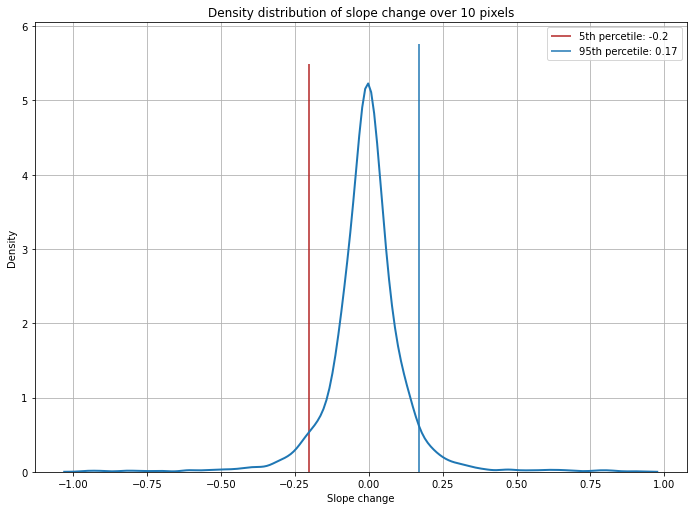

Investigating slope change over 10 pixels and the reccomend value is 0.19


In [5]:
dSlopeThr_test = findDSlopeThresholdAlternative(lsdttTable, dist = [5,10], pixThr = 7, sampleStreams = 10, mask = "testMask.shp", path = path)

## Connected Component Analysis

### First, run the CC Analysis with optimal parameters for the test region considering only those channel heads that lie within AOI polygon.

In [6]:
runCCAnalysis(fname = "testClip", path = path, lsdttTable = lsdttTable, pixThr = 7, dSlopeThr = 0.23, minCCLength = 10, bridge = 5, mask = "testMask.shp")

  0%|          | 0/33 [00:00<?, ?it/s]

There are 33 catchments.



100%|██████████| 33/33 [04:58<00:00,  9.06s/it]
/home/bodo/Dropbox/soft/github/DEM_ConnectedComponents/src/connectedComponents.py:692: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cc.columns = ["_".join(x) for x in cc.columns.ravel()]


1 stream(s) was removed, because they were shorter than the minimal required CC length.
Streams with assigned CC ID were written to testClip_ConnectedComponents_streams_7_0.23_5.csv
Aggregated parameters for all CCs were written to testClip_ConnectedComponents_7_0.23_5.csv


Clip derived connected components to AOI (optional step):

In [7]:
getCCsInAOI(fname = "testClip", path=path, mask= "testMask.shp", epsg = 32719, pixThr= 7, dSlopeThr = 0.23, bridge = 5)

The files testClip_ConnectedComponents_7_0.23_5_inAOI.csv
and testClip_ConnectedComponents_streams_7_0.23_5_inAOI.csv were written.


### Next, run CC Analysis for debris-flow sample regions

In [8]:
runCCAnalysis(fname = "debrisBasins_final", path = path, lsdttTable = debrisSamples, pixThr = 7, dSlopeThr = 0.23, minCCLength = 10, bridge = 5)

  0%|          | 0/34 [00:00<?, ?it/s]

There are 34 catchments.



100%|██████████| 34/34 [00:58<00:00,  1.72s/it]
/home/bodo/Dropbox/soft/github/DEM_ConnectedComponents/src/connectedComponents.py:692: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cc.columns = ["_".join(x) for x in cc.columns.ravel()]


1 stream(s) was removed, because they were shorter than the minimal required CC length.
Streams with assigned CC ID were written to debrisBasins_final_ConnectedComponents_streams_7_0.23_5.csv
Aggregated parameters for all CCs were written to debrisBasins_final_ConnectedComponents_7_0.23_5.csv


In the next step, we assign DFSI values using the debris-flow sample regions. These have been previously identified and clicked.

If the debris-flow samples are not available, feel free to provide your own common slope and length values for debris flows, but make sure to input length as *log(length)*.



Assigning debris-flow similarity values to all CCs intestClip_ConnectedComponents_7_0.23_5_inAOI.csv
The file debrisBasins_final_ConnectedComponents_7_0.23_5.csv is used for debris-flow samples.


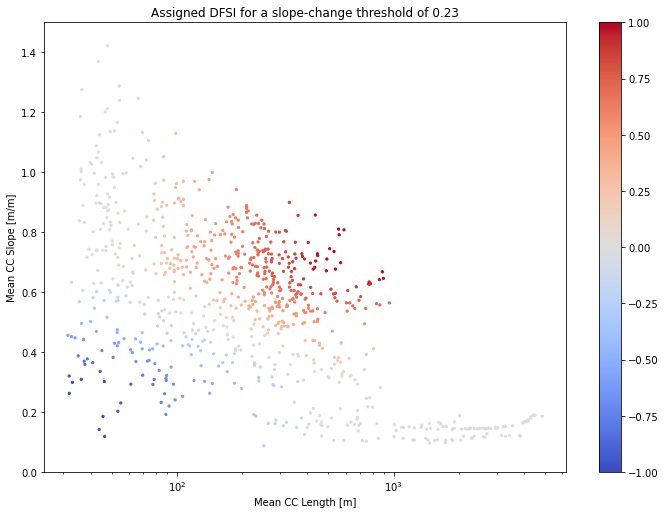

In [9]:
dfsiValues = assignDFSI( path = path, allCCName = "testClip", debrisName = "debrisBasins_final", pixThr = 7, dSlopeThr = 0.23, allExt = "_inAOI")

Let's sort the assigned DFSI values into to channel network:

In [10]:
backsorting(fname = "testClip", path = path, dfsiValues = dfsiValues, pixThr = 7, dSlopeThr = 0.23, ext = "_inAOI")

The file testClip_ConnectedComponents_streams_withDFSI_7_0.23_5.csv was written.


Plot basins with assigned DFSI (Debris-Flow Similarity Index) values in profile view.

Plotting basin(s) [9, 17] ...


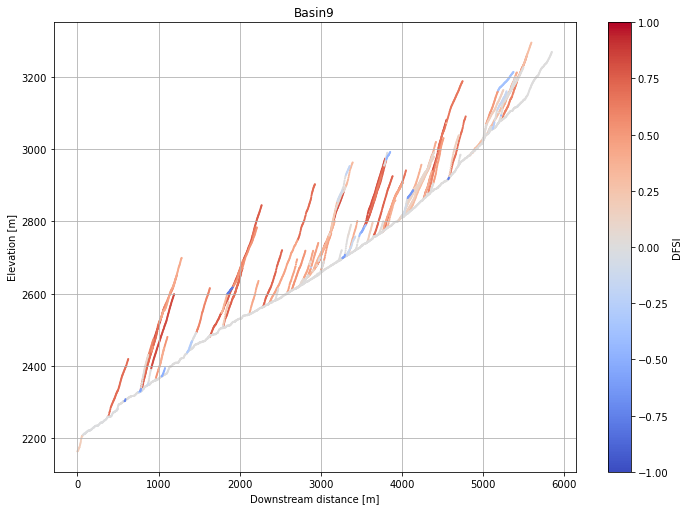

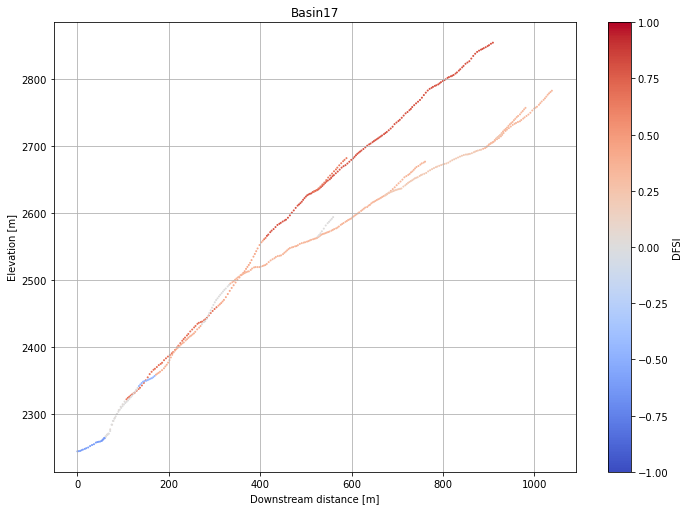

In [11]:
plotBasin("testClip", path = path, pixThr = 7, dSlopeThr = 0.23, bridge = 5, basinIDs = [9,17], colorBy = "DFSI")

You can use the same function to plot different parameters, for example *dSlopeToPrevSegment* and *segmentLocation*:

Plotting basin(s) [9, 17] ...


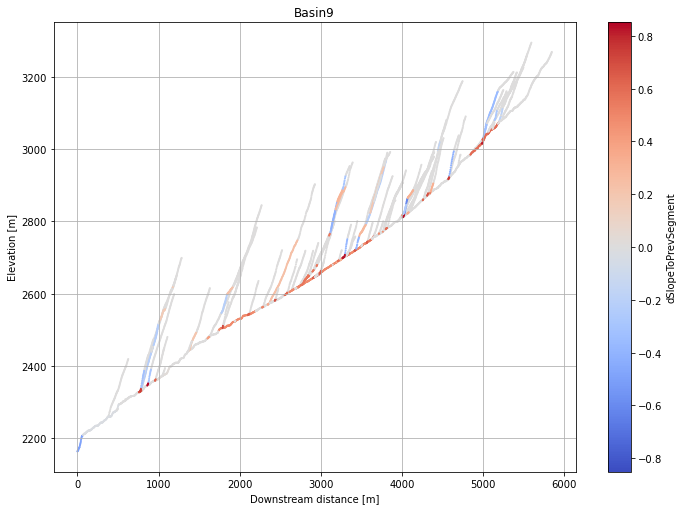

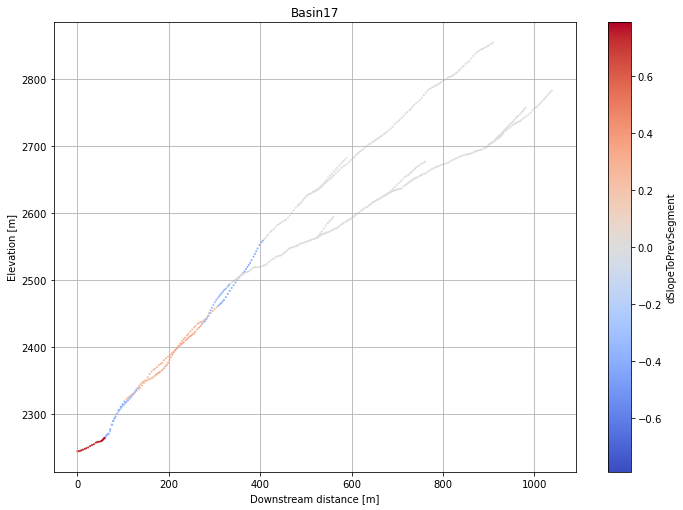

Plotting basin(s) [9, 17] ...


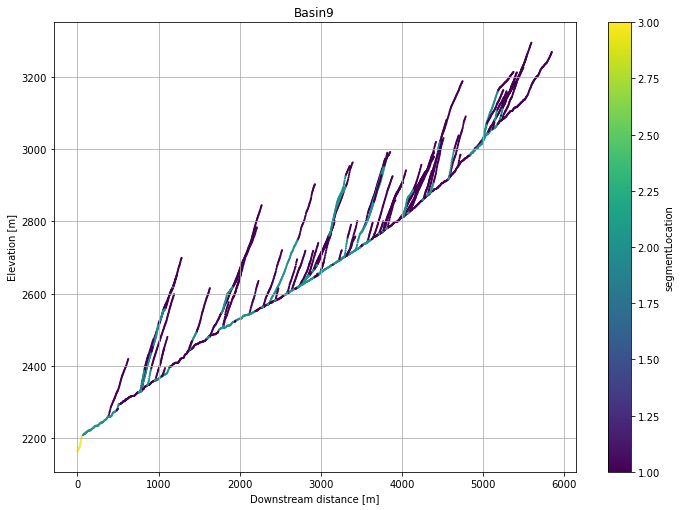

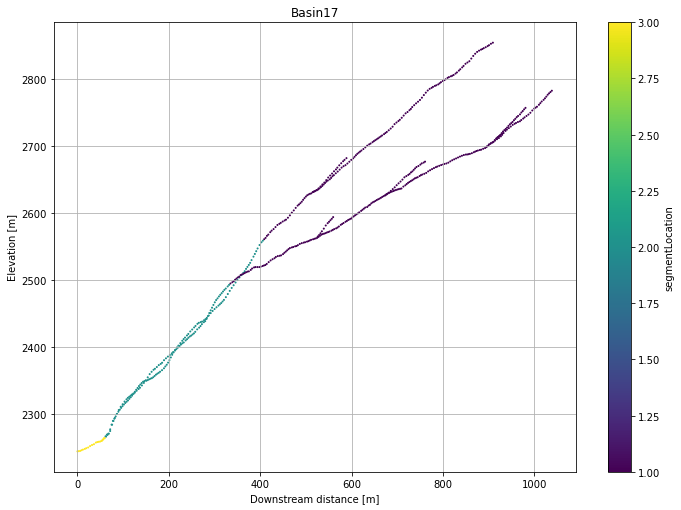

In [12]:
plotBasin("testClip", path = path, pixThr = 7, dSlopeThr = 0.23, bridge = 5, basinIDs = [9,17], colorBy = "dSlopeToPrevSegment")
plotBasin("testClip", path = path, pixThr = 7, dSlopeThr = 0.23, bridge = 5, basinIDs = [9,17], colorBy = "segmentLocation")

## Clustering
Additionally, you can cluster connected components based on various attributes

Debris-flow similarity values will be assigned to all CCs intestClip_ConnectedComponents_7_0.23_5.csv
The file debrisBasins_final_ConnectedComponents_7_0.23_5.csv is used as debris-flow sample file.
Clustering ...


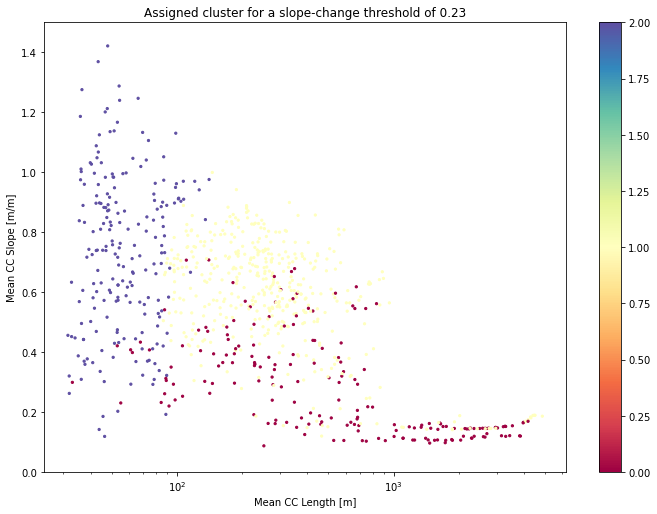

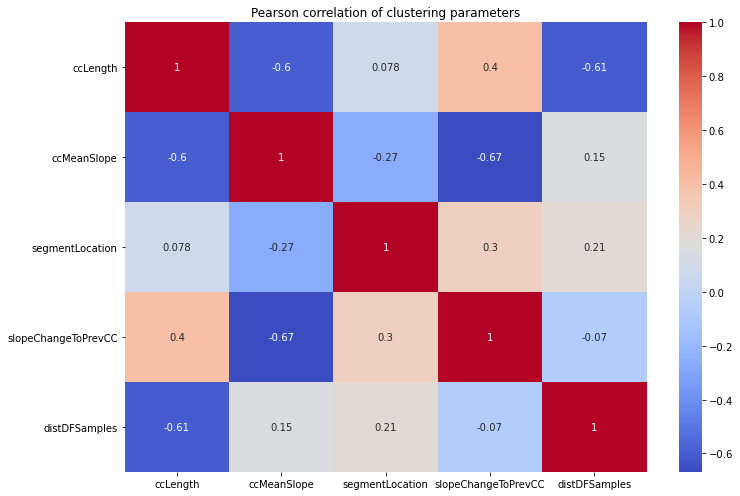

In [13]:
clusters = componentClustering(path = path, allCCName = "testClip", debrisName = "debrisBasins_final", pixThr = 7, dSlopeThr = 0.23,
                        k = 3, clusterParameters = ["ccLength", "ccMeanSlope", "segmentLocation", "slopeChangeToPrevCC", "distDFSamples"])